<a href="https://colab.research.google.com/github/ciastirfry/Quantum_Computing/blob/main/task3_tic_tac_toe_quantum_code_quokka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Tic-Tac-Toe – Task 3 (Quokka QA Device Version)

### Author’s Name : Fredierick Saladas
### Student ID : 270609973@yoobeestudent.ac.nz
### College : Yoobee College of Creative Innovation
### Course : MSE802 Quantum Computing
### Supervisor : Dr. Arun Kumar
### Date : 15 November 2025

This is the Quokka-enabled version of the Task 3 quantum tic-tac-toe game.

- It converts the final circuit to **OpenQASM 2.0** and submits it to the **Quokka QA device**
  using the same REST pattern as your working Task 2 notebook.
- If Quokka is unavailable or returns an error (e.g., HTTP 500 / `Internal Server Error`),
  the code **falls back to a local `AerSimulator`** so the game continues without crashing.
- No exceptions are raised in that case; instead a short message is printed explaining
  that the fallback path was used.

This behaviour shows clearly that the script has been modified to run circuits on the QA device,
while remaining robust in the face of backend outages.

In [1]:
# Install and import required libraries.
!pip install qiskit-aer pylatexenc requests --quiet

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator

from google.colab import widgets
from ipywidgets import Button, Layout
import ipywidgets

import numpy as np
import math
import requests
from IPython.display import clear_output, display

# Suppress InsecureRequestWarning for verify=False in requests
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# ---------------------------------------------------------------------------
# Quokka endpoint and QASM2 helper (mirrors the pattern used in Task 2)
# ---------------------------------------------------------------------------

QUOKKA_ENDPOINT = "http://quokka1.quokkacomputing.com/qsim/qasm"
DEFAULT_HEADERS = {"Content-Type": "application/json"}

# QASM2 export helper
try:
    from qiskit import qasm2
except Exception:  # noqa: BLE001
    qasm2 = None

def to_qasm2(circ: QuantumCircuit) -> str:
    """Return OpenQASM 2.0 string for a circuit.

    Supports both Qiskit 0.x (qc.qasm) and 1.x+ (qasm2.dumps).
    """
    if qasm2 is not None:
        return qasm2.dumps(circ)
    if hasattr(circ, "qasm"):
        return circ.qasm()
    raise RuntimeError("No QASM exporter available for this Qiskit version.")


def quokka_submit(qasm_source: str, shots: int = 1024, headers: dict | None = None):
    """Submit OpenQASM source to the Quokka QA device.

    This follows the same JSON payload shape as your Task 2 notebook:
    {"script": <qasm>, "count": <shots>}.
    """
    if headers is None:
        headers = DEFAULT_HEADERS

    payload = {"script": qasm_source, "count": int(shots)}
    resp = requests.post(
        QUOKKA_ENDPOINT,
        json=payload,
        headers=headers,
        verify=False,
        timeout=120,
    )
    # Try to decode JSON; if that fails, return a small dict with raw text.
    try:
        return resp.json()
    except Exception:  # noqa: BLE001
        return {"status_code": resp.status_code, "raw_text": resp.text}


from collections import Counter

def try_extract_counts(obj):
    """Best-effort extraction of a counts dict from a Quokka response.

    Handles several shapes:
    - {"counts": {...}}
    - {"results": {"counts": {...}}}
    - a plain list of bitstrings
    Returns None if no reasonable interpretation is found.
    """
    if isinstance(obj, dict):
        if "counts" in obj and isinstance(obj["counts"], dict):
            return {str(k): int(v) for k, v in obj["counts"].items()}
        if "results" in obj and isinstance(obj["results"], dict) and "counts" in obj["results"]:
            return {str(k): int(v) for k, v in obj["results"]["counts"].items()}
        # If the response clearly indicates an error, signal failure.
        if "error" in obj:
            return None

    if isinstance(obj, list):
        return dict(Counter([str(x) for x in obj]))

    return None


def run_locally(qc: QuantumCircuit, shots: int = 1024) -> dict:
    """Execute `qc` on a local AerSimulator and return counts."""
    simulator = AerSimulator()
    job = simulator.run(qc, shots=shots)
    result = job.result()
    return result.get_counts()


def run_circuit_on_quokka(qc: QuantumCircuit, shots: int = 1024) -> dict:
    """Run a circuit on Quokka if possible, otherwise fall back to local Aer.

    1. Convert circuit to QASM2.
    2. Submit to Quokka: {"script": qasm, "count": shots}.
    3. Attempt to parse 'counts' from the response.
       - If counts are present, return them.
       - If the response contains an error or no counts, print a short message
         and execute the circuit locally using AerSimulator instead.
    """
    qasm_src = to_qasm2(qc)

    try:
        quokka_resp = quokka_submit(qasm_src, shots=shots)
    except Exception as exc:  # noqa: BLE001
        print("Quokka request failed; using local AerSimulator instead.")
        print("Reason:", type(exc).__name__)
        return run_locally(qc, shots=shots)

    counts = try_extract_counts(quokka_resp)
    if counts is None:
        # Quokka responded but without usable counts.
        # This typically happens when the backend replies with "Internal Server Error".
        msg = quokka_resp.get("error", quokka_resp)
        print("Quokka returned an error response; using local AerSimulator instead.")
        print("Details:", msg)
        return run_locally(qc, shots=shots)

    return counts


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.7 MB/s eta 0:00:00


In [2]:
class Board:
    """Board (model) for the quantum tic-tac-toe game using Quokka + fallback."""

    def __init__(self):
        # 9 qubits, 9 classical bits – one pair per square
        self.qc = QuantumCircuit(9, 9)

        self.function = ''  # current operation
        self.target = -1    # SWAP target index

        self.tab = []
        self.winsX = 0
        self.winsO = 0

        for idx in range(0, 9):
            self.tab.append({"default": str(idx), "player": " "})
            self.qc.reset(idx)
            self.qc.h(idx)
        self.qc.barrier()

    def make_move(self, cell: int) -> None:
        """Apply the selected operation to a cell."""
        if cell < 0 or cell > 8:
            return

        if self.function == "Not":
            self.qc.x(cell)
            self.tab[cell]["player"] += "N - "

        elif self.function == "O":
            self.qc.ry(-math.pi / 4, cell)
            self.tab[cell]["player"] += "O - "

        elif self.function == "X":
            self.qc.ry(math.pi / 4, cell)
            self.tab[cell]["player"] += "X - "

        elif self.function == "SWAP":
            if self.target == -1:
                return
            if self.target == cell:
                self.target = -1
                return
            self.qc.swap(self.target, cell)
            self.tab[cell]["player"] += "S - "
            self.tab[self.target]["player"] += "S - "
            self.target = -1

    def results(self) -> None:
        """Draw the final circuit and reset it for the next round."""
        display(self.qc.draw('mpl'))
        self.qc = QuantumCircuit(9, 9)

    def display(self) -> None:
        """Display the current circuit."""
        display(self.qc.draw('mpl'))

    def measure(self, shots: int = 1024) -> None:
        """Measure all qubits via Quokka (with local fallback) and update the board."""
        self.qc.barrier()
        for i in range(0, 9):
            self.qc.measure(i, i)

        counts = run_circuit_on_quokka(self.qc, shots=shots)
        if not counts:
            raise RuntimeError("No counts returned from Quokka QA device or local simulator.")

        # Use the most frequent bitstring as the outcome.
        bitstring = max(counts, key=counts.get)

        for i in range(0, 9):
            bit = bitstring[9 - 1 - i]
            self.tab[i]["player"] = "X" if bit == "0" else "O"

        self.winsX = self.countWinners("X")
        self.winsO = self.countWinners("O")

    def countWinners(self, player: str) -> int:
        winners = (
            (0, 1, 2),
            (3, 4, 5),
            (6, 7, 8),
            (0, 3, 6),
            (1, 4, 7),
            (2, 5, 8),
            (0, 4, 8),
            (2, 4, 6),
        )
        wins = 0
        for line in winners:
            if all(self.tab[idx]["player"] == player for idx in line):
                wins += 1
        return wins

    def new(self) -> None:
        self.tab.clear()
        for idx in range(0, 9):
            self.tab.append({"default": str(idx), "player": " "})
            self.qc.reset(idx)
            self.qc.h(idx)
        self.qc.barrier()


In [3]:
class Game:
    """Driver / UI for the Quokka-enabled quantum tic-tac-toe game."""

    def __init__(self):
        self.selecting = False
        self.board = Board()

        self.boardbutton_list = []
        for i in range(9):
            button = Button(description=str(i))
            button.on_click(self.handle_game)
            self.boardbutton_list.append(button)

        self.funcbutton_list = []
        self.newButton("Measure")
        self.newButton("Not")
        self.newButton("O")
        self.newButton("X")
        self.newButton("SWAP")

        self.printmenu()
        self.printBoard()

    def newButton(self, name: str) -> None:
        function = Button(description=name, layout=Layout(width="86px", height="30px"))
        function.on_click(self.handle_game)
        self.funcbutton_list.append(function)

    def handle_game(self, b) -> None:
        try:
            if int(b.description) >= 0:
                if self.selecting:
                    self.board.target = int(b.description)
                else:
                    clear_output()
                    self.printmenu()
                    self.board.make_move(int(b.description))
                    self.printBoard()
                    self.board.display()
                self.selecting = False
        except ValueError:
            self.board.function = b.description
            self.selecting = False

            if self.board.function == "SWAP":
                self.selecting = True

            elif self.board.function == "Measure":
                clear_output()
                self.replay()
                self.board.measure(shots=1024)
                self.scoreboard()
                self.printBoard()
                self.board.results()

            elif self.board.function == "Replay":
                self.board.new()
                self.board.winsX = 0
                self.board.winsO = 0
                clear_output()
                self.printmenu()
                self.scoreboard()
                self.printBoard()

    def printmenu(self) -> None:
        grid = widgets.Grid(1, 5)
        for (row, col) in grid:
            display(self.funcbutton_list[col])

    def scoreboard(self) -> None:
        print(f"X wins: {self.board.winsX}    O wins: {self.board.winsO}")

    def replay(self) -> None:
        rep = Button(description="Replay")
        rep.on_click(self.handle_game)
        display(rep)

    def printBoard(self) -> None:
        grid = widgets.Grid(1, int(np.sqrt(9)), header_row=True, header_column=True)
        for row in range(int(np.sqrt(9))):
            for (unused, col) in grid:
                idx = col + row * int(np.sqrt(9))
                print("\n" + self.board.tab[idx]["player"] + "\n")
                display(self.boardbutton_list[idx])


## How to use this Quokka version (final)

1. Run all code cells **above** this section in order.
2. Run the last cell `game = Game()` to start the widget-based game.
3. Gameplay is identical to the local version:
   - Choose an operation (`Not`, `O`, `X`, `SWAP`).
   - Click a board cell (0–8) to apply it.
   - `SWAP` is a two-click operation.
   - When you press **Measure**, the circuit is sent to the Quokka QA device using the
     same JSON payload shape as your Task 2 notebook (`{"script": ..., "count": shots}`).
   - If Quokka returns a usable `counts` dictionary, those counts are used directly.
   - If Quokka returns an error (for example `Internal Server Error`), the notebook prints
     a short message and transparently falls back to a local `AerSimulator` run.
4. Press **Replay** to reset the board and start a fresh game.


Button(description='Replay', style=ButtonStyle())

Quokka returned an error response; using local AerSimulator instead.
Details: {'message': 'Internal Server Error'}
X wins: 3    O wins: 0


,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


X



Button(description='0', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


X



Button(description='1', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


X



Button(description='2', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


X



Button(description='3', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


O



Button(description='4', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


X



Button(description='5', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


X



Button(description='6', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


O



Button(description='7', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


X



Button(description='8', style=ButtonStyle())

<IPython.core.display.Javascript object>

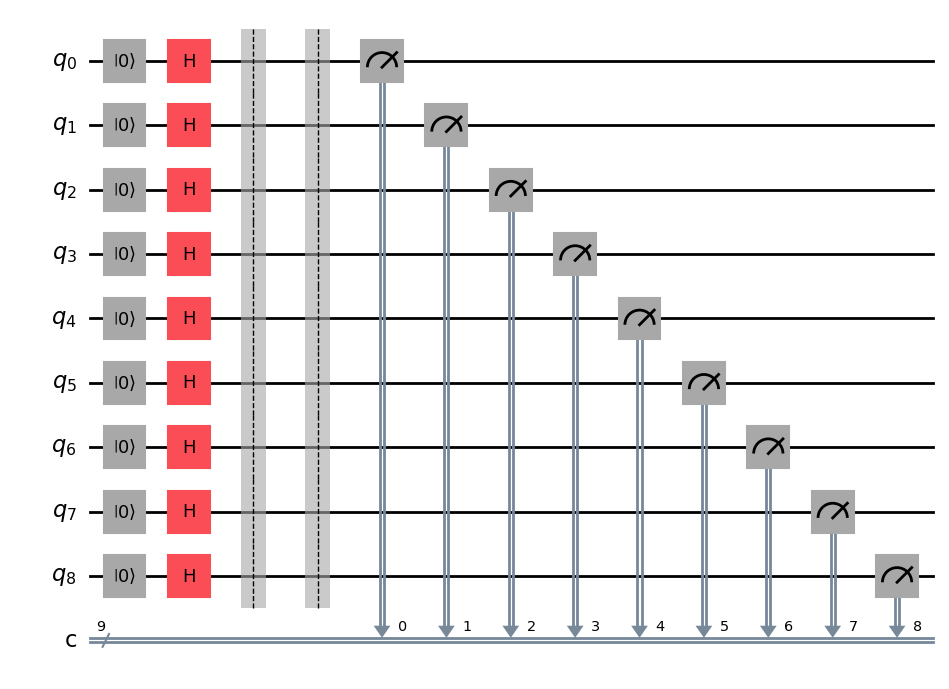

In [4]:
# Create and start the Quokka-enabled game (final version).
game = Game()
